# Visualizzazione dei dati

In [1]:
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
# Si recuperano i dataset relativi alla mobilità.
mobilità = pd.read_csv('allegati/dataset/mobilita-lombardia-2020.csv')

In [3]:
# Si recupera il dizionario contenente le zone colorate.
zone_covid_2020 = json.load(open('allegati/dataset/zone-covid-2020.json', 'r'))

In [4]:
# Si inizializza la lista dei mesi, utile per l'etichetta dell'asse delle x.
mesi = ['Gennaio', 'Febbraio', 'Marzo', 'Aprile', 'Maggio', 'Giugno', 'Luglio', 'Agosto', 'Settembre', 'Ottobre', 'Novembre', 'Dicembre']

# Si crea la lista di tipi.
tipi = {
    'retail_and_recreation':'Retail e tempo libero',
    'grocery_and_pharmacy':'Alimentari e farmacie',
    'parks':'Parchi',
    'transit_stations':'Stazioni trasporto pubblico',
    'workplaces':'Luoghi di lavoro',
    'residential':'Zone residenziali'
}

In [5]:
# Si definiscono le palette per i lineplot.
colori = ['navy', 'darkcyan', 'forestgreen', 'firebrick', 'darkmagenta', 'sienna']
palette_lineplot = sns.color_palette(colori)
# Si crea anche il relativo dizionario.
palette_lineplot_dict = dict()
for tipo, i in zip(tipi.keys(), range(0, len(colori))):
    palette_lineplot_dict[tipo] = colori[i]

Si definisce una funzione che dato il mese stampa il resoconto degli spostamenti ad esso relativo

In [6]:
def ottieni_colore_per_giorno(mese, giorno):
    # Si recupera il file contenente le zone.
    global zone_covid_2020

    # Per ogni record...
    for record in zone_covid_2020:
        # ... si recuperano le date di inzio e fine del periodo...
        data_inizio_split, data_fine_split = record['inizio'].split('-'), record['fine'].split('-')
        data_inizio_record = datetime.datetime(int(data_inizio_split[0]), int(data_inizio_split[1]), int(data_inizio_split[2]))
        data_fine_record = datetime.datetime(int(data_fine_split[0]), int(data_fine_split[1]), int(data_fine_split[2]))
        # ... si ricrea la data passata come parametro...
        data = datetime.datetime(2020, mese, giorno)
        # ... e, se il giorno è nell'intervallo...
        if data >= data_inizio_record and data < data_fine_record:
            return record['colore']

Le componenti sono pronte, si procede a visualizzare i dati.

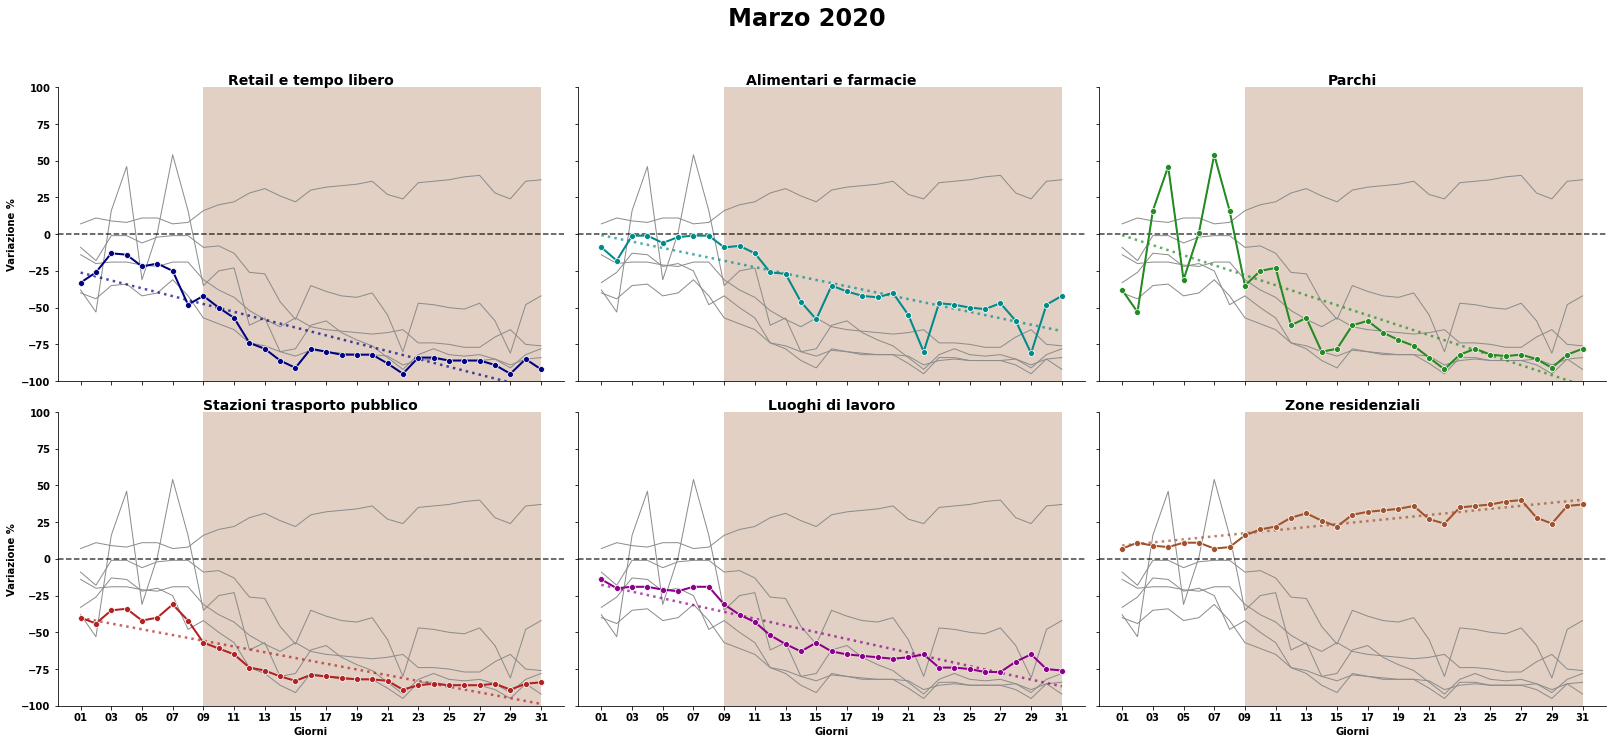

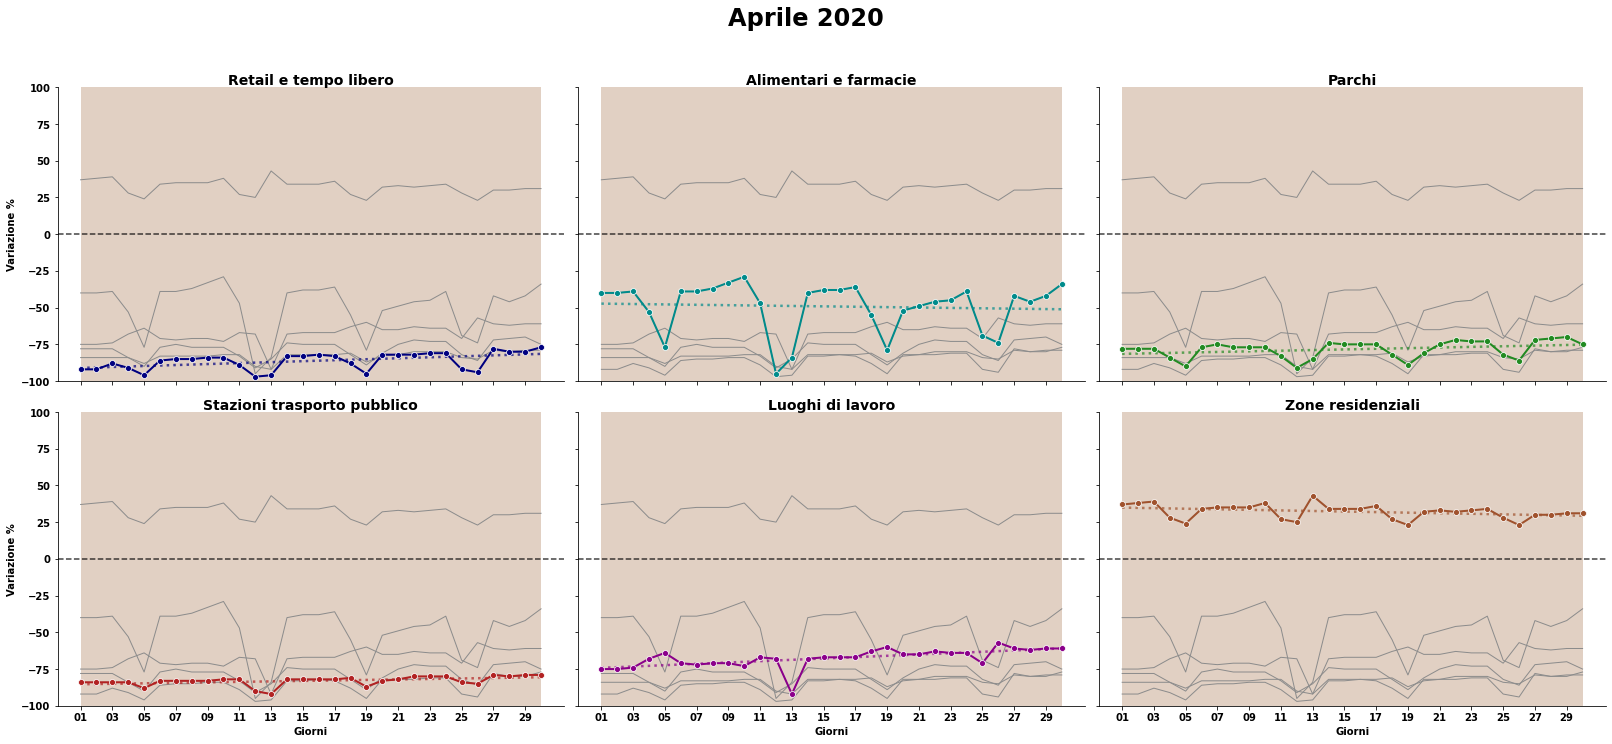

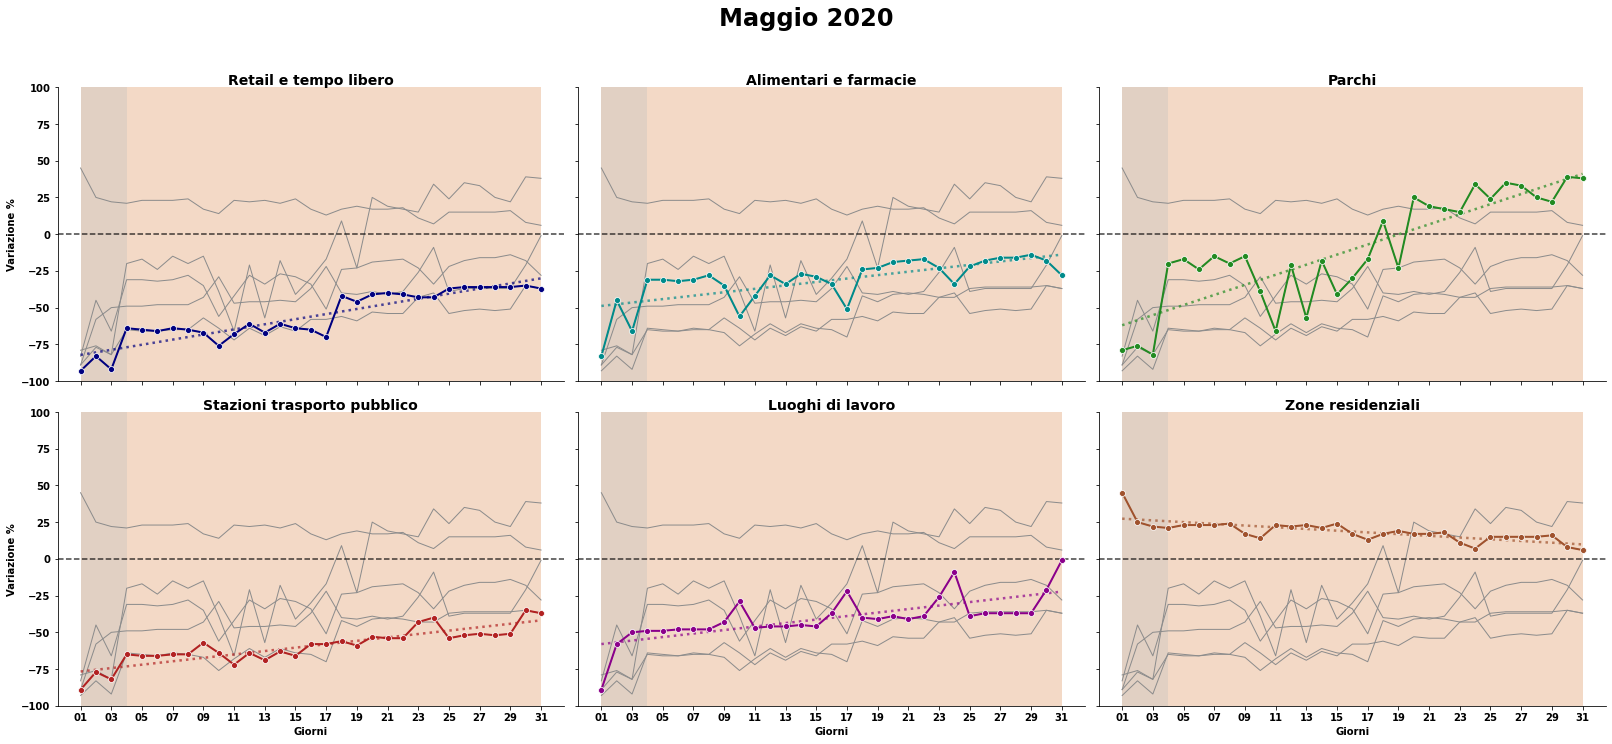

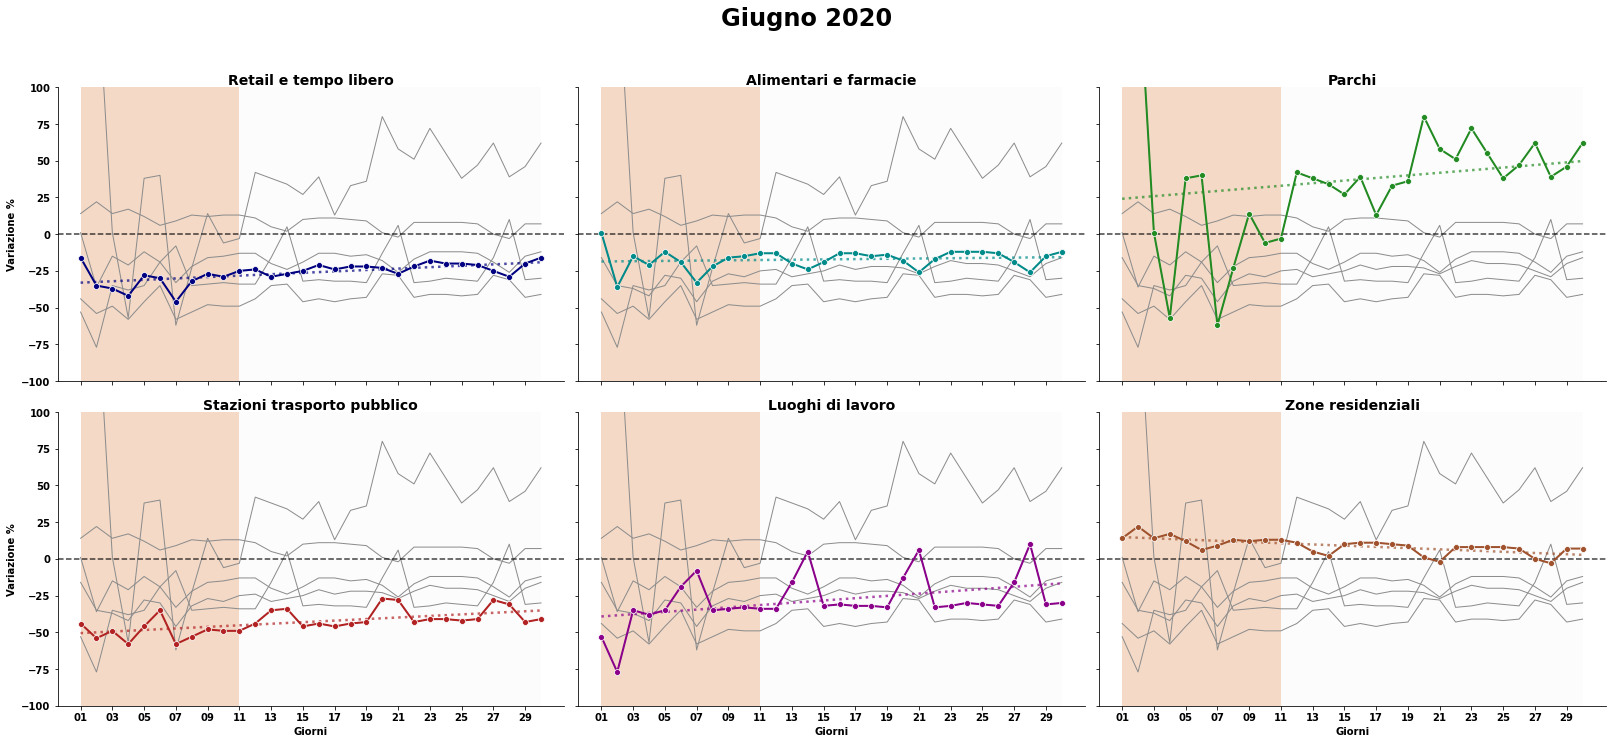

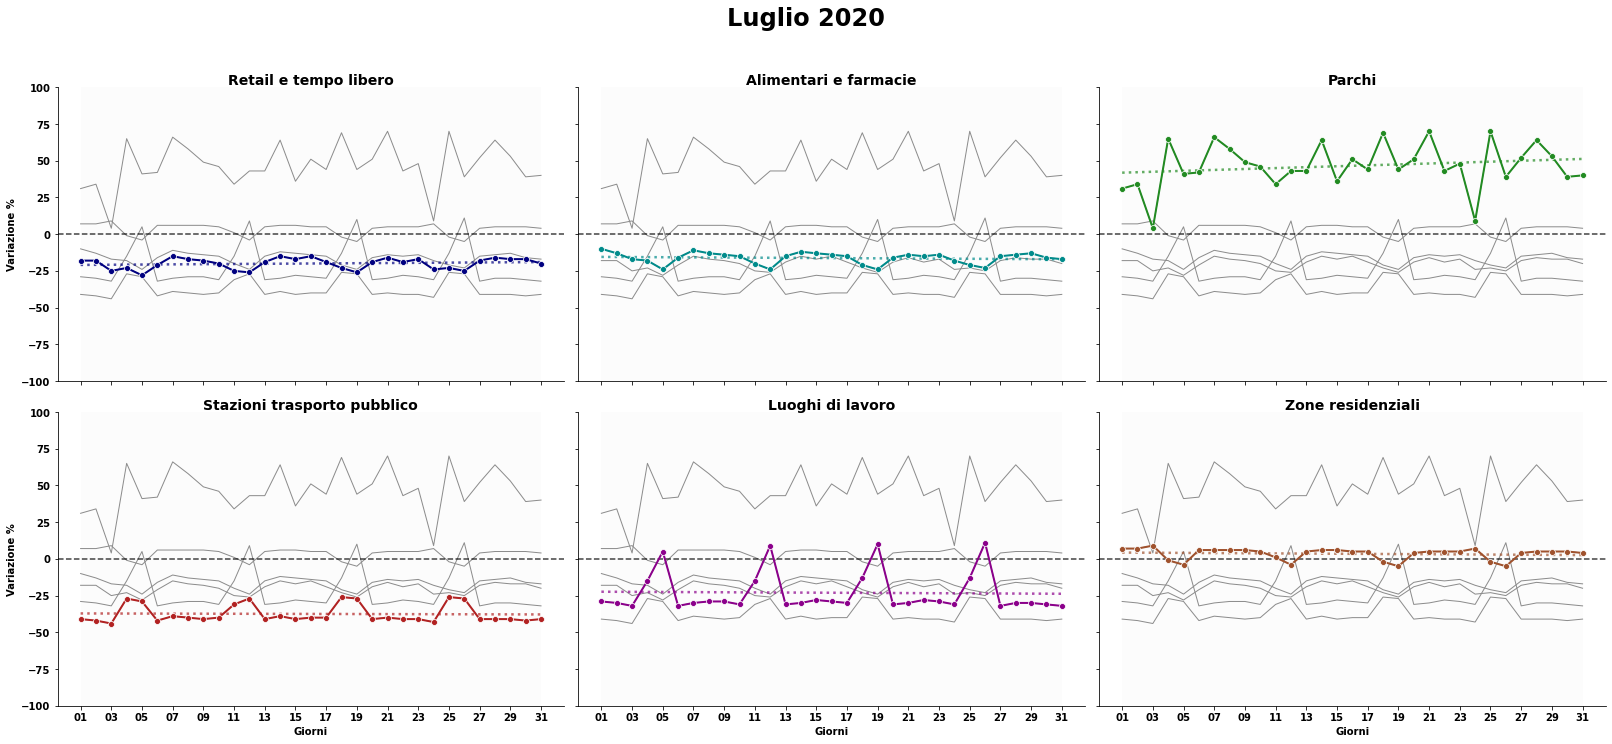

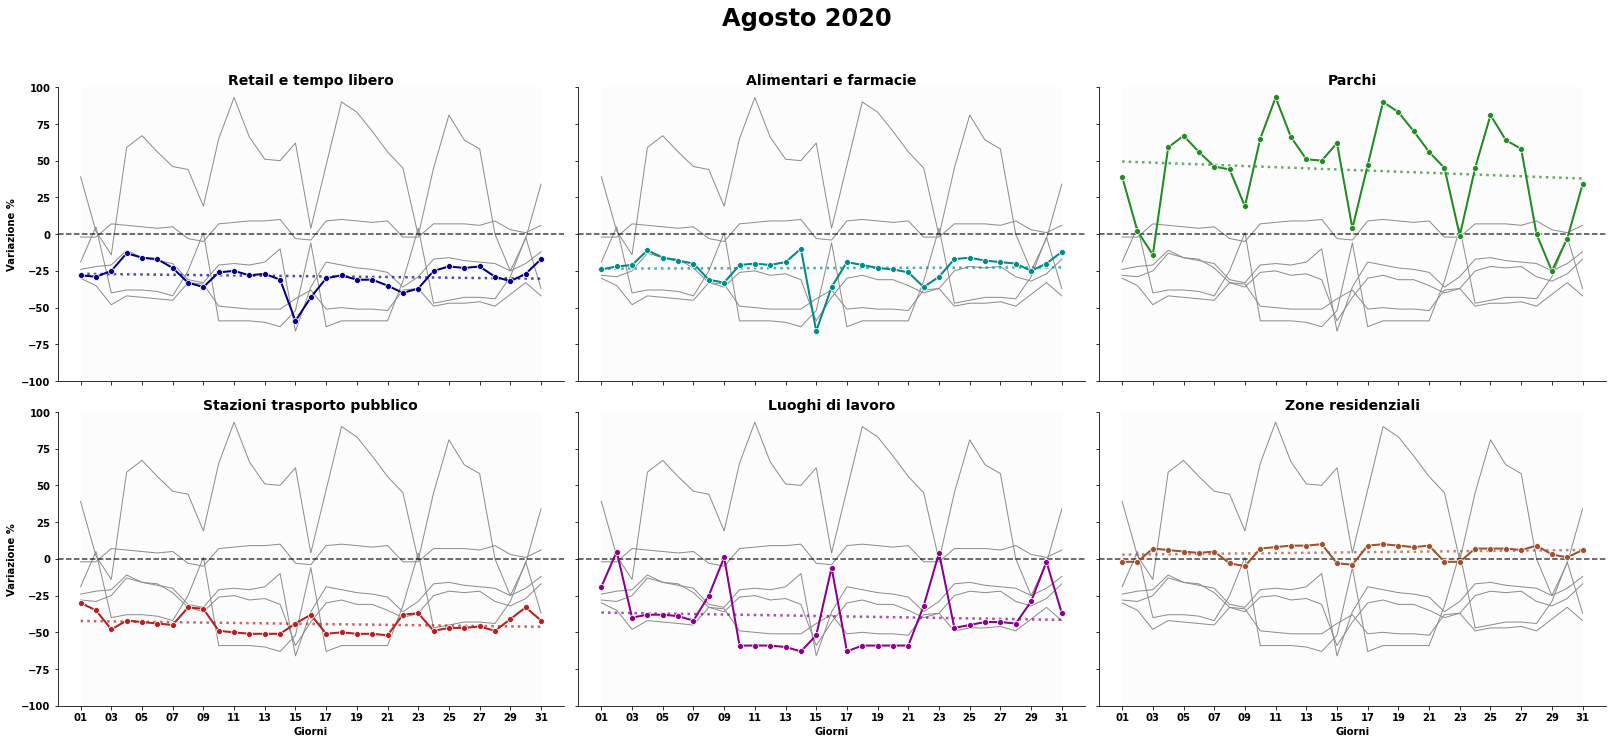

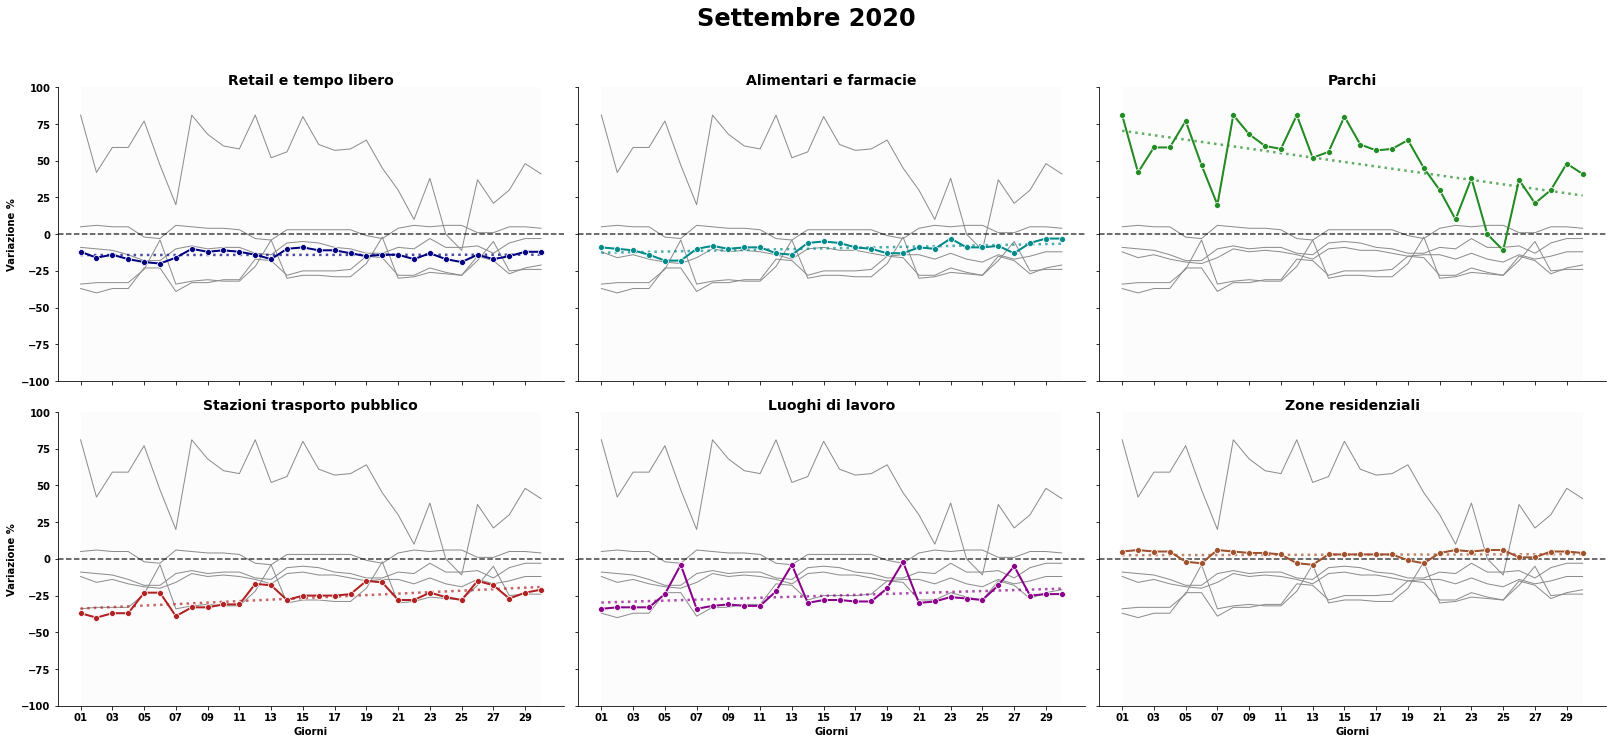

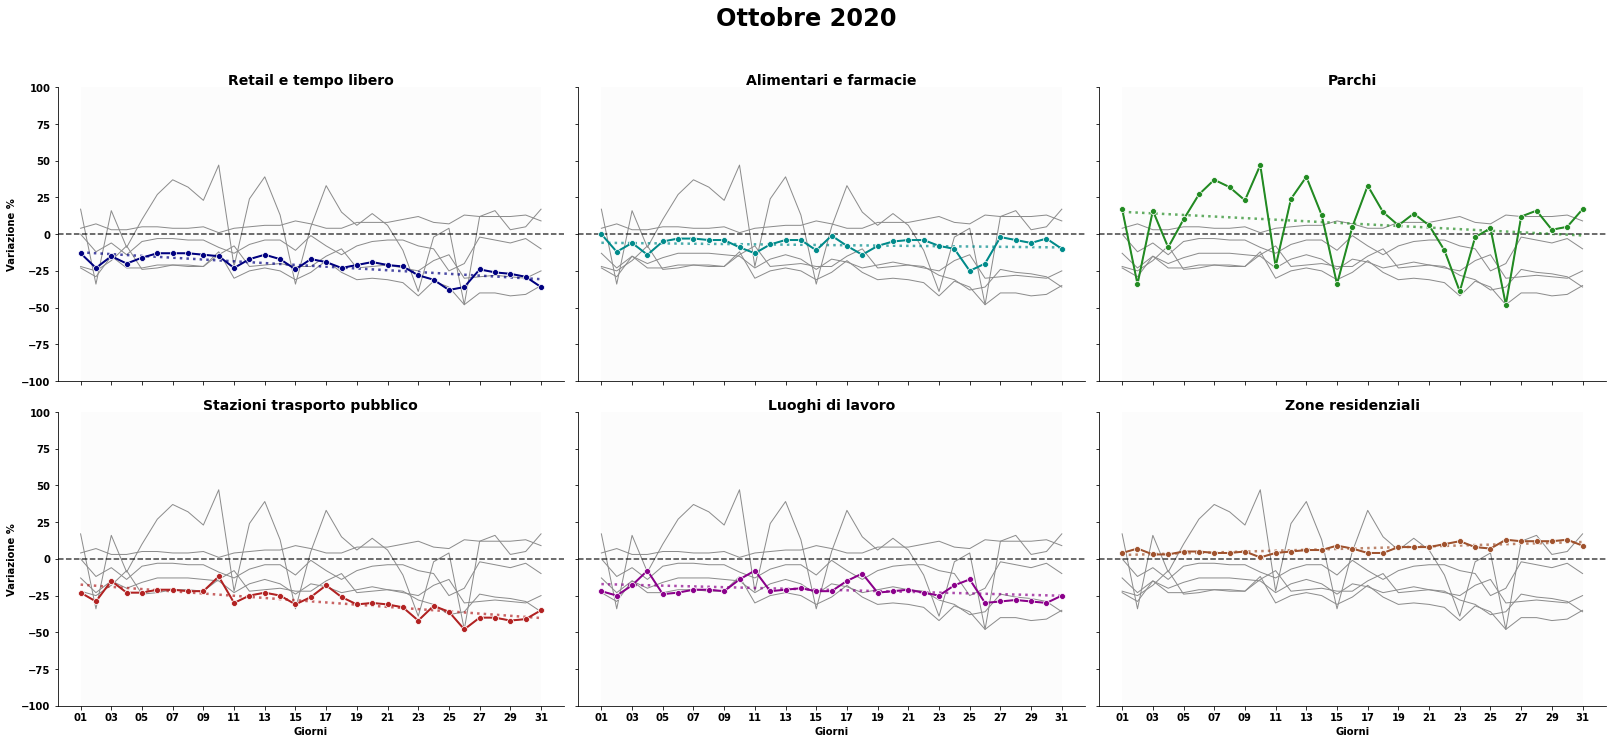

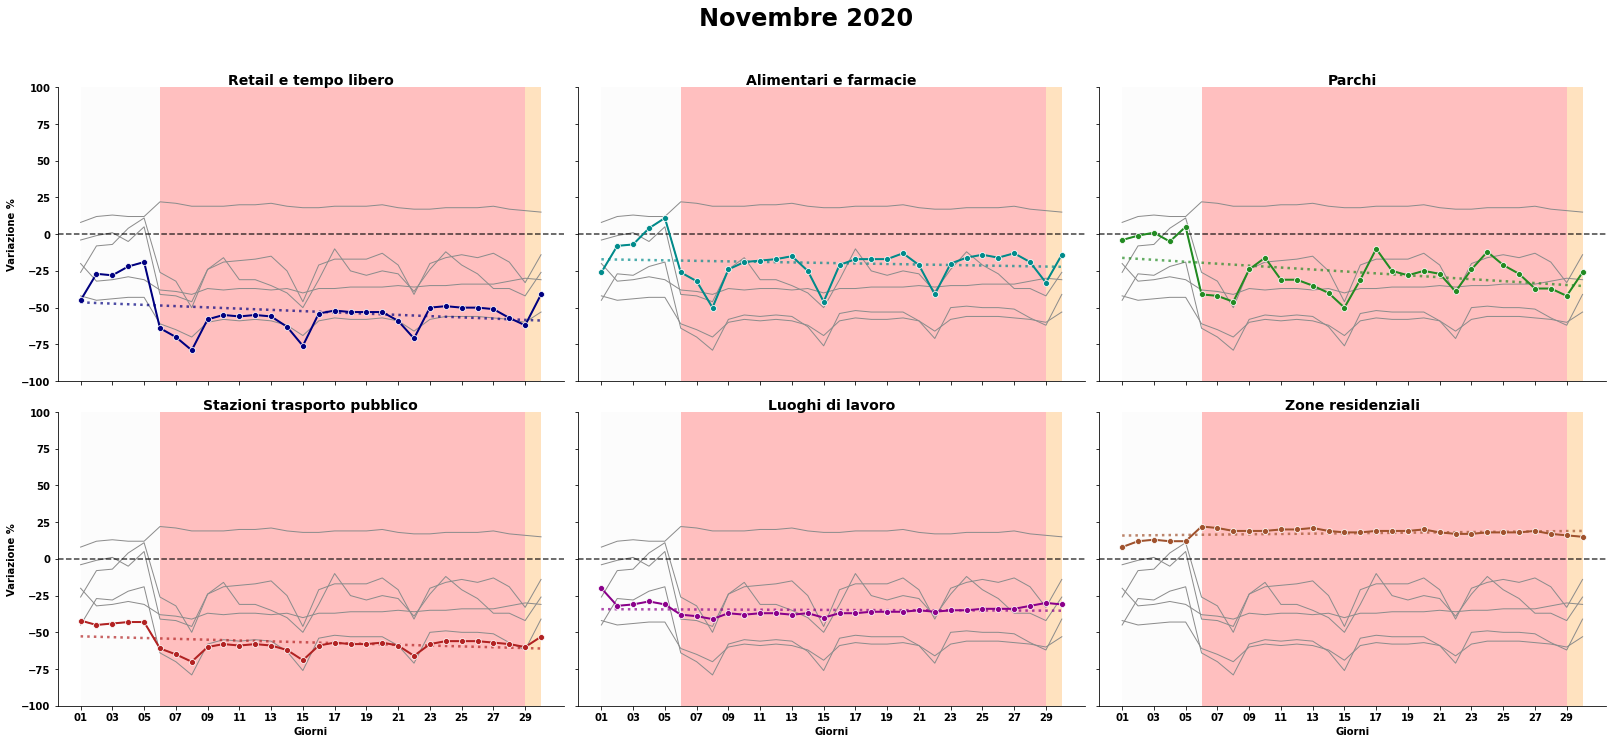

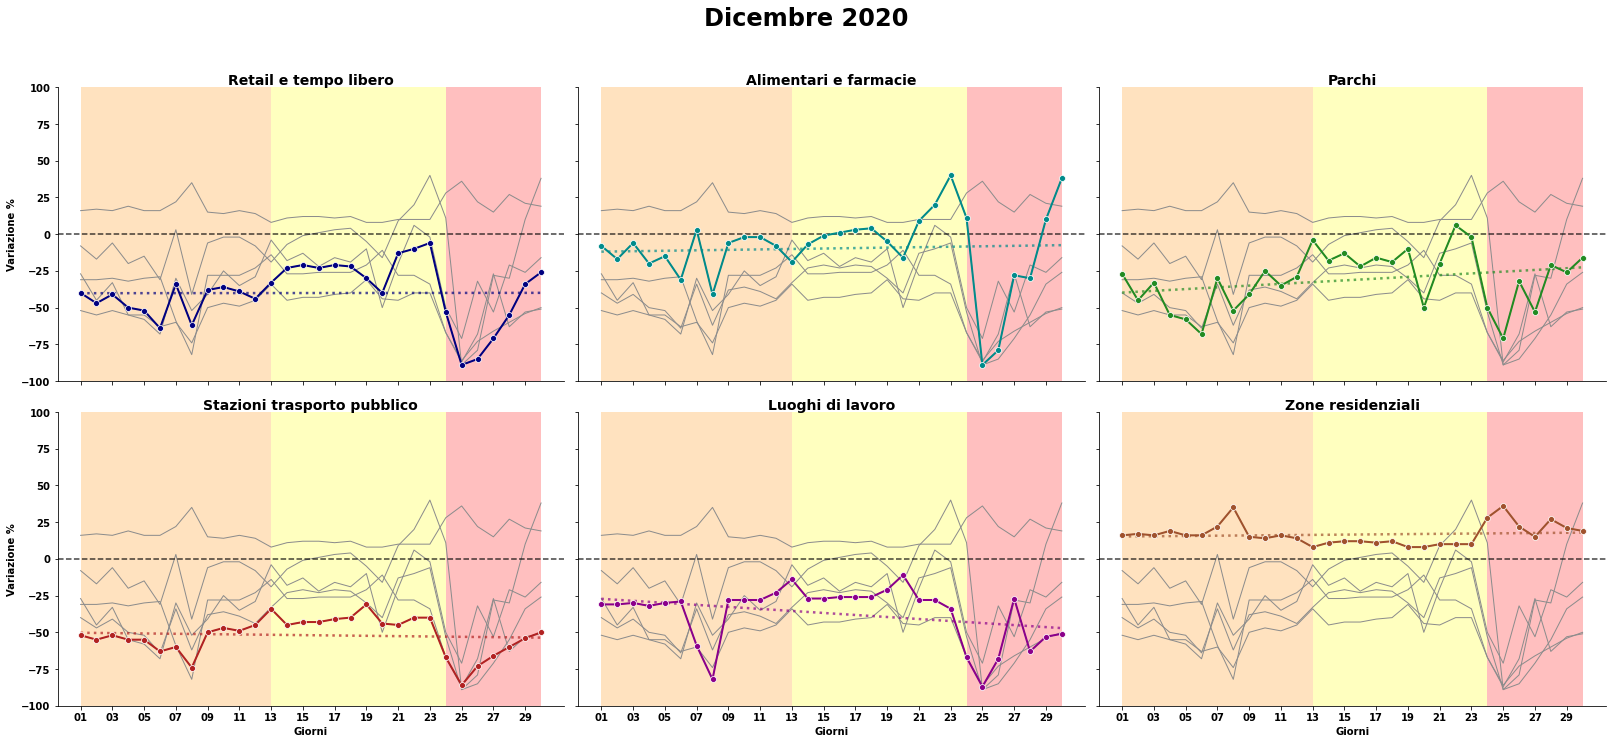

In [7]:
# Per ogni mese...
for mese in range(3, 13):
    # Si recuperano le righe del dataset relative al mese desiderato
    mobilità_desiderata = [record[1] for record in mobilità.iterrows() if int(record[1]['Data'].split('/')[1]) == mese]

    # Per ogni record della lista...
    for record in mobilità_desiderata:
        # ... si modifica la data tenendo solo il giorno.
        record['Data'] = record['Data'].split('/')[-1]

    # Si ricrea il dataset usando le righe modificate.
    mobilità_desiderata = pd.DataFrame(mobilità_desiderata)

    # Si crea la facet contenente i grafici vuoti divisi per tipo.
    g = sns.relplot(data=mobilità_desiderata, x='Data', y='Valore', col='Tipo', hue='Tipo', kind='line', linewidth=2, zorder=5, col_wrap=3, height=5, aspect=1.5, legend=False, marker="o", palette=palette_lineplot)
    # Si setta il titolo.
    g.fig.suptitle(mesi[mese - 1]+' 2020', y=1.0125, fontsize=24, horizontalalignment='center', verticalalignment='center')

    # Si recuperano le date di inzio delle zone.
    date_inizio = [datetime.datetime(int(record['inizio'].split('-')[0]), int(record['inizio'].split('-')[1]), int(record['inizio'].split('-')[2])) for record in zone_covid_2020]

    # Per ogni sottoplot...
    for tipo, ax in g.axes_dict.items():
        # ... si aggiunge il titolo come annotazione...
        ax.text(0.5, 1, tipi[tipo], transform=ax.transAxes, fontsize=14, fontweight="bold", ha='center', va='bottom')
        # ... e si mostra il plot del singolo tipo.
        plot = sns.lineplot(data=mobilità_desiderata, x='Data', y='Valore', units='Tipo', estimator=None, color='.55', linewidth=1, ax=ax)
        # Si aggiune una linea orizzontale per y=0.
        ax.axhline(0, ls='--', color='black', alpha=0.75)

        # Si recupera la mobilità desiderata dato il tipo.
        mobilità_desiderata_per_tipo = pd.DataFrame([riga[1] for riga in mobilità_desiderata.iterrows() if riga[1]['Tipo'] == tipo])
        # Linear regressions for each sex
        z = np.polyfit([float(record) for record in mobilità_desiderata_per_tipo['Data']], [float(record) for record in mobilità_desiderata_per_tipo['Valore']], 1)
        p = np.poly1d(z)
        ax.plot(mobilità_desiderata_per_tipo['Data'], p([float(record) for record in mobilità_desiderata_per_tipo['Data']]), c=palette_lineplot_dict[tipo], ls=":", linewidth=2.5, alpha=0.7)
            
        # Per ogni giorno...
        for giorno in range(0, int(mobilità_desiderata['Data'].max()) - 1):
            # ... si visualizzano delle aree sotto il punto del colore della zona covid.
            plot.axvspan(giorno, giorno+1, facecolor=ottieni_colore_per_giorno(mese, giorno + 1), alpha=0.25)

    # Si settano i limiti dell'asse delle ordinate.
    ax.set(ylim=(-100, 100))
    # Si riduce la frequenza dei marker.
    ax.set_xticks(ax.get_xticks()[::2])

    # Si settano il titolo dei vari sottografici e le assi.
    g.set_titles('')
    g.set_axis_labels('Giorni', 'Variazione %')
    # Si mostra il grafico con un layout thight.
    g.tight_layout()
        
    # Si salva l'immagine.
    plt.savefig('allegati/immagini/mesi/lineplot/mobilita-{}-2020.png'.format(mesi[mese - 1].lower()), bbox_inches='tight')

Si creano gli small multiple relativi a tutti i mesi in analisi.

In [8]:
# Per la palette dei barplot, si definisce un colore per grafico.
palette_barplot = {}
# Per ogni tipo...
for tipo, indice in zip(tipi.values(), range(0, 6)):
    # Si crea una palette tutta uguale.
    palette = sns.color_palette([colori[indice] for i in range(0, 10)])
    # Si aggiunge la palette al dizionario
    palette_barplot[tipo] = palette

In [9]:
# Si calcolano i dati medi relativi alla mobilità. Si inizializza una variabile contenitore per i nuovi dati...
valori_per_tipo = []
# ... si recuperano i dati relativi al mese. Per ogni tipo...
for tipo in tipi.keys():
    # ... per ogni mese...
    for mese in range(3, 13):
        # ... si estrae la mobilità verso retail e tempo libero nel mese scelto.
        mobilità_desiderata = [record[1] for record in mobilità.iterrows() if int(record[1]['Data'].split('/')[1]) == mese and record[1]['Tipo'] == tipo]

        # Si ricrea il dataset usando le righe modificate.
        mobilità_desiderata = pd.DataFrame(mobilità_desiderata)

        # Si crea un dataset per la media.
        mobilità_desiderata_per_media = pd.DataFrame(mobilità_desiderata)['Valore']

        # Si visualizza la misurazione.
        valori_per_tipo.append({'Mese':mesi[mese - 1], 'Tipo':tipi[tipo], 'Media':mobilità_desiderata.mean(axis=0)['Valore']})

# Si crea il dataset definitivo.
mobilità_desiderata_per_tipo = pd.DataFrame(valori_per_tipo)

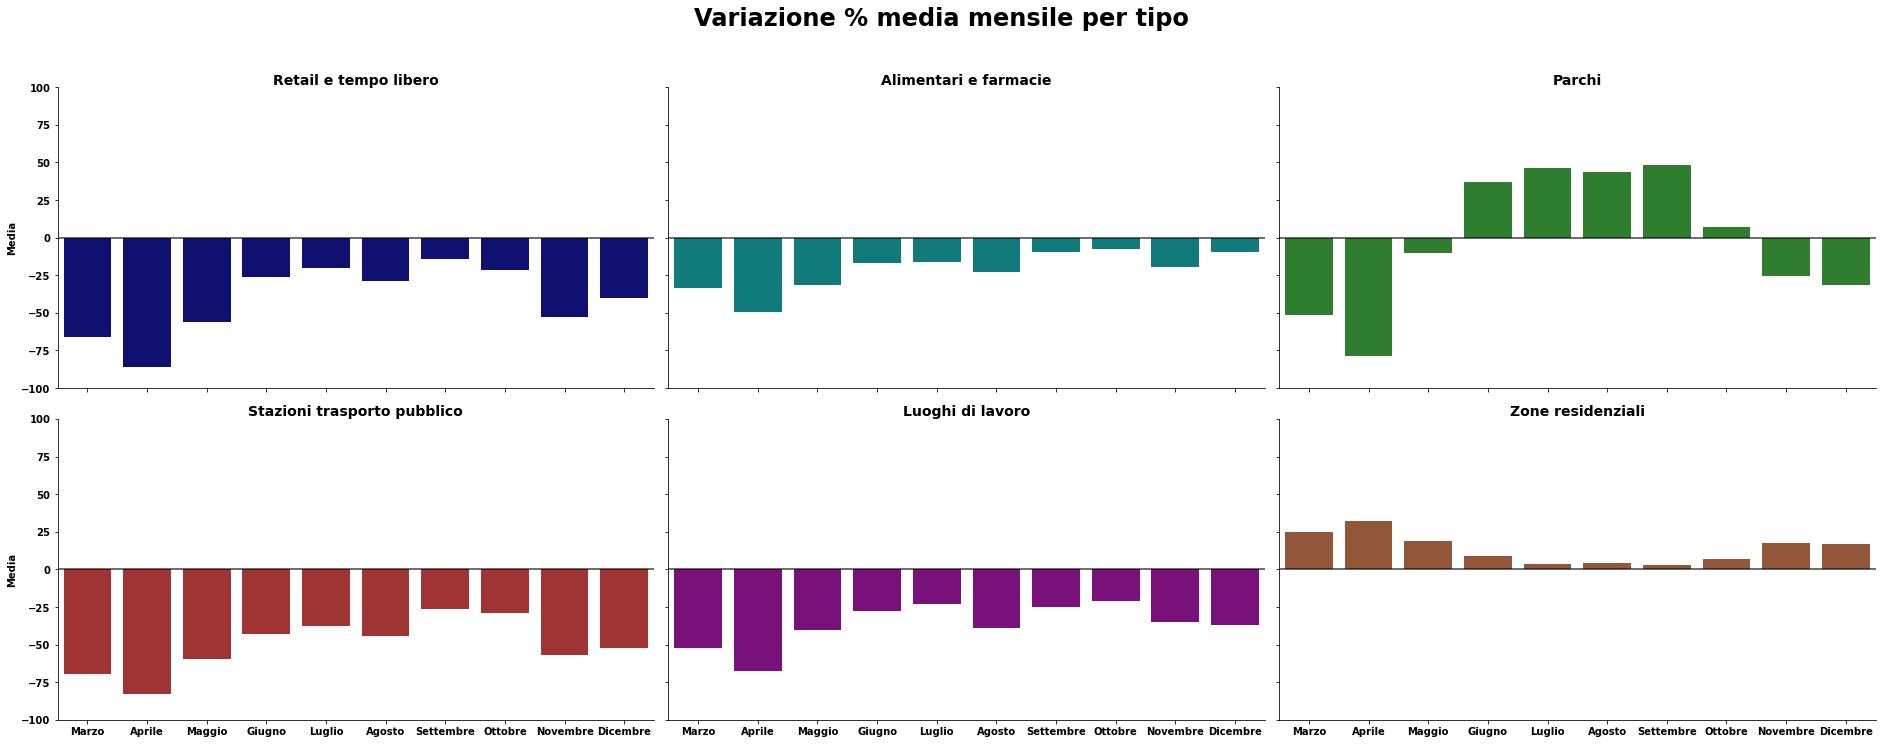

In [10]:
# Si inizializza il contenitore per lo small multiple.
g = sns.FacetGrid(mobilità_desiderata_per_tipo, col='Tipo', col_wrap=3, height=5, aspect=1.75)
# Si setta il titolo.
g.fig.suptitle('Variazione % media mensile per tipo', y=1.0125, fontsize=24, horizontalalignment='center', verticalalignment='center')

# Per ogni sottoplot...
for tipo, ax in g.axes_dict.items():
    # ... si aggiunge il titolo come annotazione...
    ax.text(0.5, 1, tipo, transform=ax.transAxes, fontsize=14, fontweight="bold", ha='center', va='bottom')
        
    # ... si filtra il dataset...
    valori_desiderati = [record[1] for record in mobilità_desiderata_per_tipo.iterrows() if record[1]['Tipo'] == tipo]
    # ... lo si ricrea...
    mobilità_desiderata = pd.DataFrame(valori_desiderati)
    # .. si rimuove la colonna 'Tipo'...
    mobilità_desiderata = mobilità_desiderata.drop(['Tipo'], axis=1)

    # ... e si mostra il plot del singolo tipo.
    sns.barplot(x="Mese", y="Media", data=mobilità_desiderata, ax=ax, palette=palette_barplot[tipo])
    # Si aggiune una linea orizzontale per y=0.
    ax.axhline(0, ls='-', color='black', alpha=0.75)

# Si settano i limiti dell'asse delle ordinate.
ax.set(ylim=(-100, 100))

# Si settano il titolo degli assi.
g.set_axis_labels('', 'Media')
# Si mostra il grafico con un layout thight.
g.tight_layout()

# Si salva l'immagine.
plt.savefig('allegati/immagini/tipi/barplot-mobilita-per-tipo.png', bbox_inches='tight')

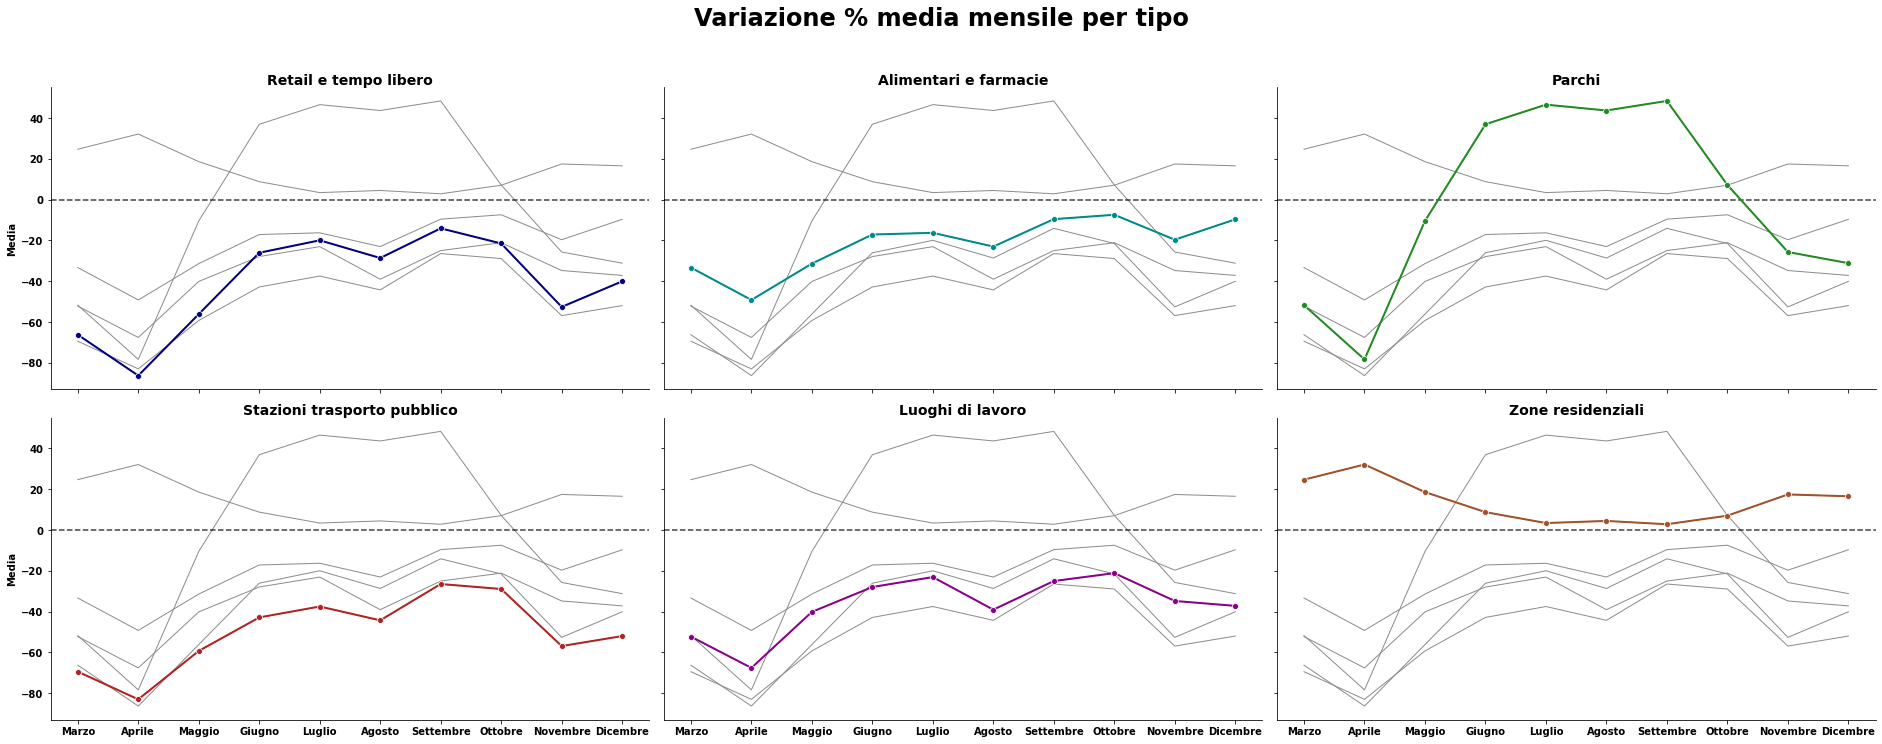

In [11]:
# Si crea la facet contenente i grafici vuoti divisi per tipo.
g = sns.relplot(data=mobilità_desiderata_per_tipo, x='Mese', y='Media', col='Tipo', hue='Tipo', kind='line', linewidth=2, zorder=5, col_wrap=3, height=5, aspect=1.75, legend=False, marker="o", palette=palette_lineplot)
# Si setta il titolo.
g.fig.suptitle('Variazione % media mensile per tipo', y=1.0125, fontsize=24, horizontalalignment='center', verticalalignment='center')

# Per ogni sottoplot...
for tipo, ax in g.axes_dict.items():
    # ... si aggiunge il titolo come annotazione...
    ax.text(0.5, 1, tipo, transform=ax.transAxes, fontsize=14, fontweight="bold", ha='center', va='bottom')
    # ... e si mostra il plot del singolo tipo.
    plot = sns.lineplot(data=mobilità_desiderata_per_tipo, x='Mese', y='Media', units='Tipo', estimator=None, color='.55', linewidth=1, ax=ax)
    # Si aggiune una linea orizzontale per y=0.
    ax.axhline(0, ls='--', color='black', alpha=0.75)

# Si settano il titolo degli assi.
g.set_titles('')
g.set_axis_labels('', 'Media')
# Si mostra il grafico con un layout thight.
g.tight_layout()

# Si salva l'immagine.
plt.savefig('allegati/immagini/tipi/lineplot-mobilita-per-tipo.png', bbox_inches='tight')

Si visualizzano i radar plot relativi alla mobilità per mese.

In [12]:
import spiderplot as sp

In [13]:
# Si imposta il font delle labels.
font = {'size': 12}
plt.rc('font', **font)

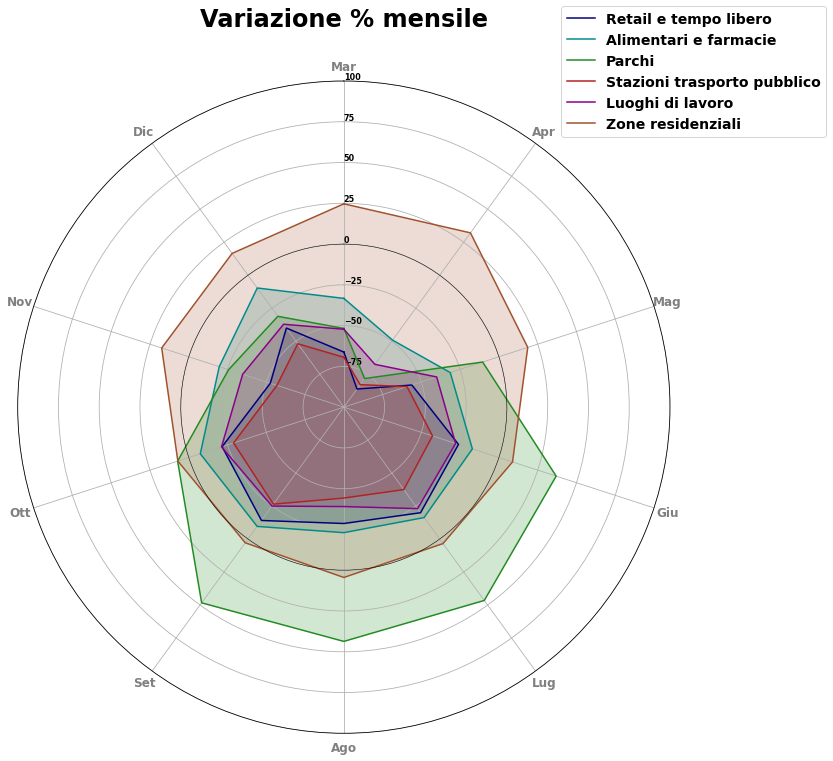

In [14]:
# Si crea un dataset contenente le medie dei mesi per tipo.
mobilità_generale = pd.DataFrame(columns=['Mese', 'Tipo', 'Valore'])
# Per ogni mese...
for mese in range(3, 13):
    # ... si estraggono i dati relativi al mese in esame.
    mobilità_desiderata = [record[1] for record in mobilità.iterrows() if int(record[1]['Data'].split('/')[1]) == mese]

    # Per ogni tipo...
    for tipo in tipi.keys():
        # .. si recupera la mobilità relativa.
        mobilità_per_tipo = [record['Valore'] for record in mobilità_desiderata if record['Tipo'] == tipo]
        # Si calcola la media.
        media_tipo = np.mean(mobilità_per_tipo)
        # Si aggiunge il record al dataset.
        mobilità_generale = mobilità_generale.append({'Mese':mesi[mese - 1][:3], 'Tipo':tipi[tipo], 'Valore':media_tipo}, ignore_index=True)

    
# Si setta la dimensione dell'immagine
plt.figure(figsize=(12, 12))

# Si traccia il plot per il mese in esame.
plot = sp.spiderplot(x="Mese", y="Valore", hue="Tipo", legend=True, data=mobilità_generale, palette=palette_lineplot, rref=0, alpha=1)

# Si sposta la legenda.
plot.legend(loc="upper right", bbox_to_anchor=(1.25, 1.125), fontsize=10, prop={'size': 14})

# Si setta il titolo.
plot.set_title('Variazione % mensile', y=1.085, fontsize=24, horizontalalignment='center', verticalalignment='center')

# Si settano i limiti dell'asse delle ordinate.
plot.set(ylim=(-100, 100))

# Si salva l'immagine.
plt.savefig('allegati/immagini/mesi/radarplot/radarplot-mobilita-2020.png', bbox_inches='tight')

# Si mostra il grafico.
plt.show()

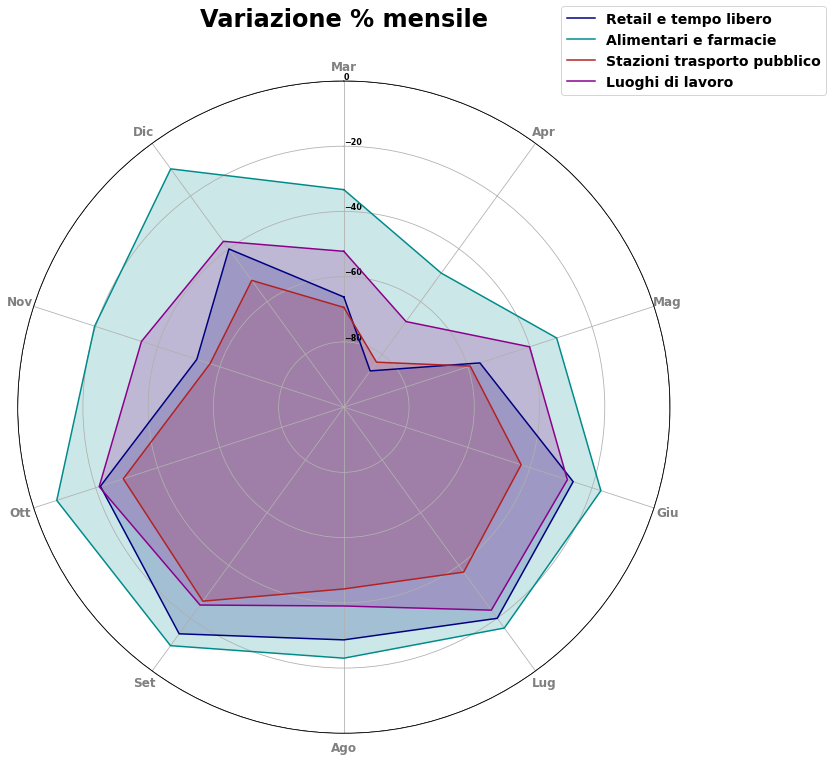

In [15]:
# Si crea un dataset contenente le medie dei mesi per tipo.
mobilità_generale = pd.DataFrame(columns=['Mese', 'Tipo', 'Valore'])
# Per ogni mese...
for mese in range(3, 13):
    # ... si estraggono i dati relativi al mese in esame.
    mobilità_desiderata = [record[1] for record in mobilità.iterrows() if int(record[1]['Data'].split('/')[1]) == mese]

    # Per ogni tipo...
    for tipo in tipi.keys():
        # Se il tipo è 'parks' o 'residential' si interrompe il ciclo.
        if tipo in ['parks', 'residential']:
            continue

        # .. si recupera la mobilità relativa.
        mobilità_per_tipo = [record['Valore'] for record in mobilità_desiderata if record['Tipo'] == tipo]
        # Si calcola la media.
        media_tipo = np.mean(mobilità_per_tipo)
        # Si aggiunge il record al dataset.
        mobilità_generale = mobilità_generale.append({'Mese':mesi[mese - 1][:3], 'Tipo':tipi[tipo], 'Valore':media_tipo}, ignore_index=True)

    
# Si setta la dimensione dell'immagine
plt.figure(figsize=(12, 12))

# Si filtra la palette tenendo conto solo dei valori considerati.
palette_lineplot_negativi = sns.color_palette(['navy', 'darkcyan', 'firebrick', 'darkmagenta'])

# Si traccia il plot per il mese in esame.
plot = sp.spiderplot(x="Mese", y="Valore", hue="Tipo", legend=True, data=mobilità_generale, palette=palette_lineplot_negativi, rref=0, alpha=1)

# Si sposta la legenda.
plot.legend(loc="upper right", bbox_to_anchor=(1.25, 1.125), fontsize=10, prop={'size': 14})

# Si setta il titolo.
plot.set_title('Variazione % mensile', y=1.085, fontsize=24, horizontalalignment='center', verticalalignment='center')

# Si settano i limiti dell'asse delle ordinate.
plot.set(ylim=(-100, 0))

# Si salva l'immagin
plt.savefig('allegati/immagini/mesi/radarplot/radarplot-negativi-mobilita-2020.png', bbox_inches='tight')

# Si mostra il grafico.
plt.show()

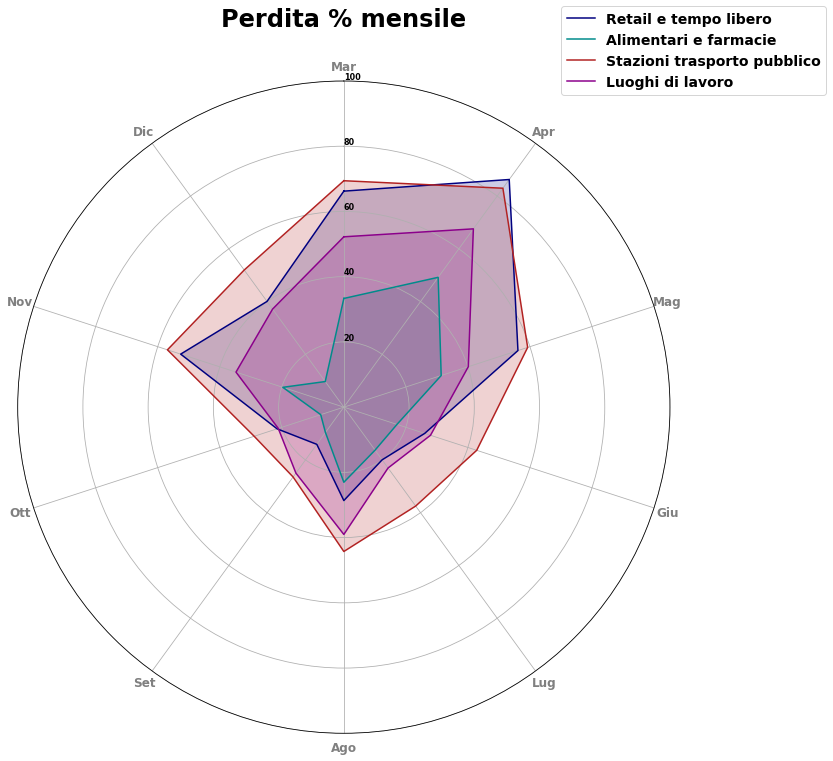

In [16]:
# Si crea un dataset contenente le medie dei mesi per tipo.
mobilità_generale = pd.DataFrame(columns=['Mese', 'Tipo', 'Valore'])
# Per ogni mese...
for mese in range(3, 13):
    # ... si estraggono i dati relativi al mese in esame.
    mobilità_desiderata = [record[1] for record in mobilità.iterrows() if int(record[1]['Data'].split('/')[1]) == mese]

    # Per ogni tipo...
    for tipo in tipi.keys():
        # Se il tipo è 'parks' o 'residential' si interrompe il ciclo.
        if tipo in ['parks', 'residential']:
            continue

        # .. si recupera la mobilità relativa.
        mobilità_per_tipo = [record['Valore'] for record in mobilità_desiderata if record['Tipo'] == tipo]
        # Si calcola la media.
        media_tipo = np.mean(mobilità_per_tipo)
        # Si aggiunge il record al dataset.
        mobilità_generale = mobilità_generale.append({'Mese':mesi[mese - 1][:3], 'Tipo':tipi[tipo], 'Valore':abs(media_tipo)}, ignore_index=True)

    
# Si setta la dimensione dell'immagine
plt.figure(figsize=(12, 12))

# Si filtra la palette tenendo conto solo dei valori considerati.
palette_lineplot_negativi = sns.color_palette(['navy', 'darkcyan', 'firebrick', 'darkmagenta'])

# Si traccia il plot per il mese in esame.
plot = sp.spiderplot(x="Mese", y="Valore", hue="Tipo", legend=True, data=mobilità_generale, palette=palette_lineplot_negativi, rref=0, alpha=1)

# Si sposta la legenda.
plot.legend(loc="upper right", bbox_to_anchor=(1.25, 1.125), fontsize=10, prop={'size': 14})

# Si setta il titolo.
plot.set_title('Perdita % mensile', y=1.085, fontsize=24, horizontalalignment='center', verticalalignment='center')

# Si settano i limiti dell'asse delle ordinate.
plot.set(ylim=(0, 100))

# Si salva l'immagin
plt.savefig('allegati/immagini/mesi/radarplot/radarplot-negativi-abs-mobilita-2020.png', bbox_inches='tight')

# Si mostra il grafico.
plt.show()

Si visualizzano gli slope chart relativi alla mobilità. Si definisce una funzione che presa una data renda la relativa restrizione.

In [17]:
def ottieni_restrizione_per_giorno(data):
    # Si recupera il file contenente le zone.
    global zone_covid_2020

    # Per ogni record...
    for record in zone_covid_2020:
        # ... si recuperano le date di inzio e fine del periodo...
        data_inizio_split, data_fine_split = record['inizio'].split('-'), record['fine'].split('-')
        data_inizio_record = datetime.datetime(int(data_inizio_split[0]), int(data_inizio_split[1]), int(data_inizio_split[2]))
        data_fine_record = datetime.datetime(int(data_fine_split[0]), int(data_fine_split[1]), int(data_fine_split[2]))
        # ... si ricrea la data passata come parametro...
        data_calcolata = datetime.datetime(int(data.split('/')[0]), int(data.split('/')[1]), int(data.split('/')[-1]))
        # ... e, se il giorno è nell'intervallo...
        if data_calcolata >= data_inizio_record and data_calcolata < data_fine_record:
            return record['restrizioni']

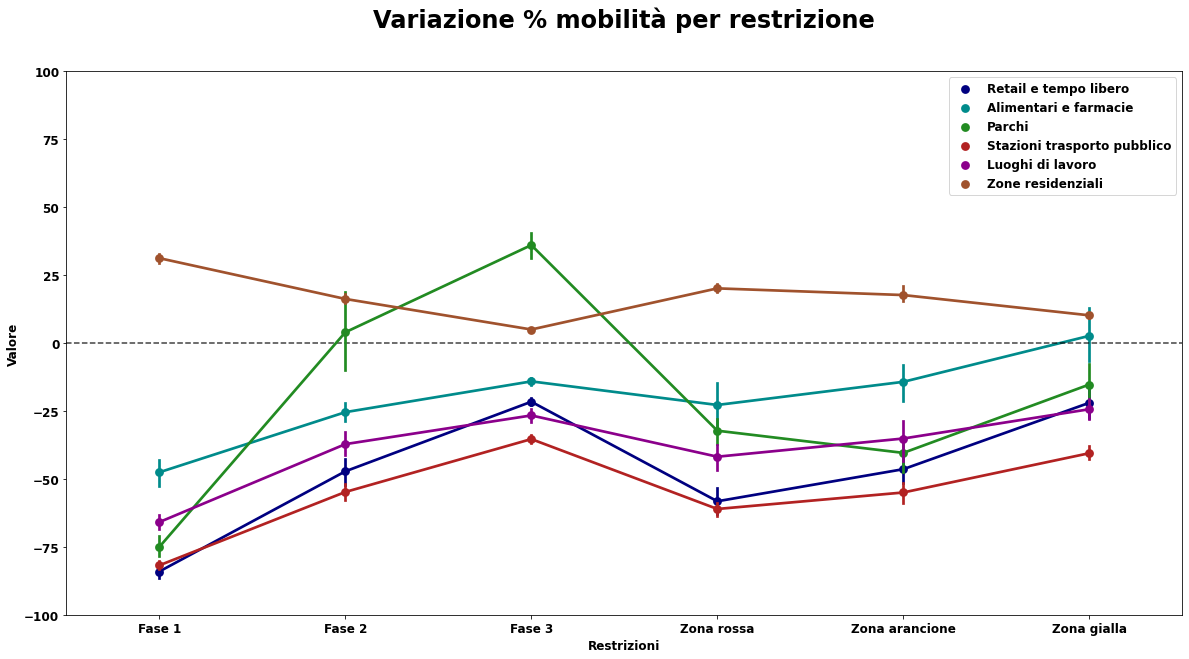

In [18]:
# Si crea un nuovo dataset diviso per fasi (Fase 1, Fase 2 e Fase 3).
mobilità_con_fasi = pd.DataFrame(columns=['Fase', 'Tipo', 'Valore'])
# Per ogni record del dataset precedente...
for record in mobilità.iterrows():
    # ... si salva anche l'informazione delle restrizioni nel nuovo dataset.
    mobilità_con_fasi = mobilità_con_fasi.append({'Restrizioni':ottieni_restrizione_per_giorno(record[1]['Data']), 'Tipo':tipi[record[1]['Tipo']], 'Valore':record[1]['Valore']}, ignore_index=True)

# Si tolgono i record relativi alla zona senza restrizioni.
mobilità_con_fasi = mobilità_con_fasi.drop(mobilità_con_fasi[mobilità_con_fasi['Restrizioni'] == 'Nessuna restrizione'].index)

# Si setta la dimensione dell'immagine
plt.figure(figsize=(20, 10))

# Si traccia lo slope chart.
plot = sns.pointplot(x='Restrizioni', y='Valore', hue='Tipo', data=mobilità_con_fasi, palette=palette_lineplot)

# Si aggiune una linea orizzontale per y=0.
plot.axhline(0, ls='--', color='black', alpha=0.75)

# Si rimuove il titolo della legenda.
handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles, labels=labels, title='')

# Si setta il titolo.
plot.set_title('Variazione % mobilità per restrizione', y=1.085, fontsize=24, horizontalalignment='center', verticalalignment='center')

# Si settano i limiti dell'asse delle ordinate.
plot.set(ylim=(-100, 100))

# Si salva l'immagine.
plt.savefig('allegati/immagini/tipi/slope-chart-mobilita-2020.png', bbox_inches='tight')

Si confrontano gli andamenti dei vari tipi con "Alimentari e farmacie".

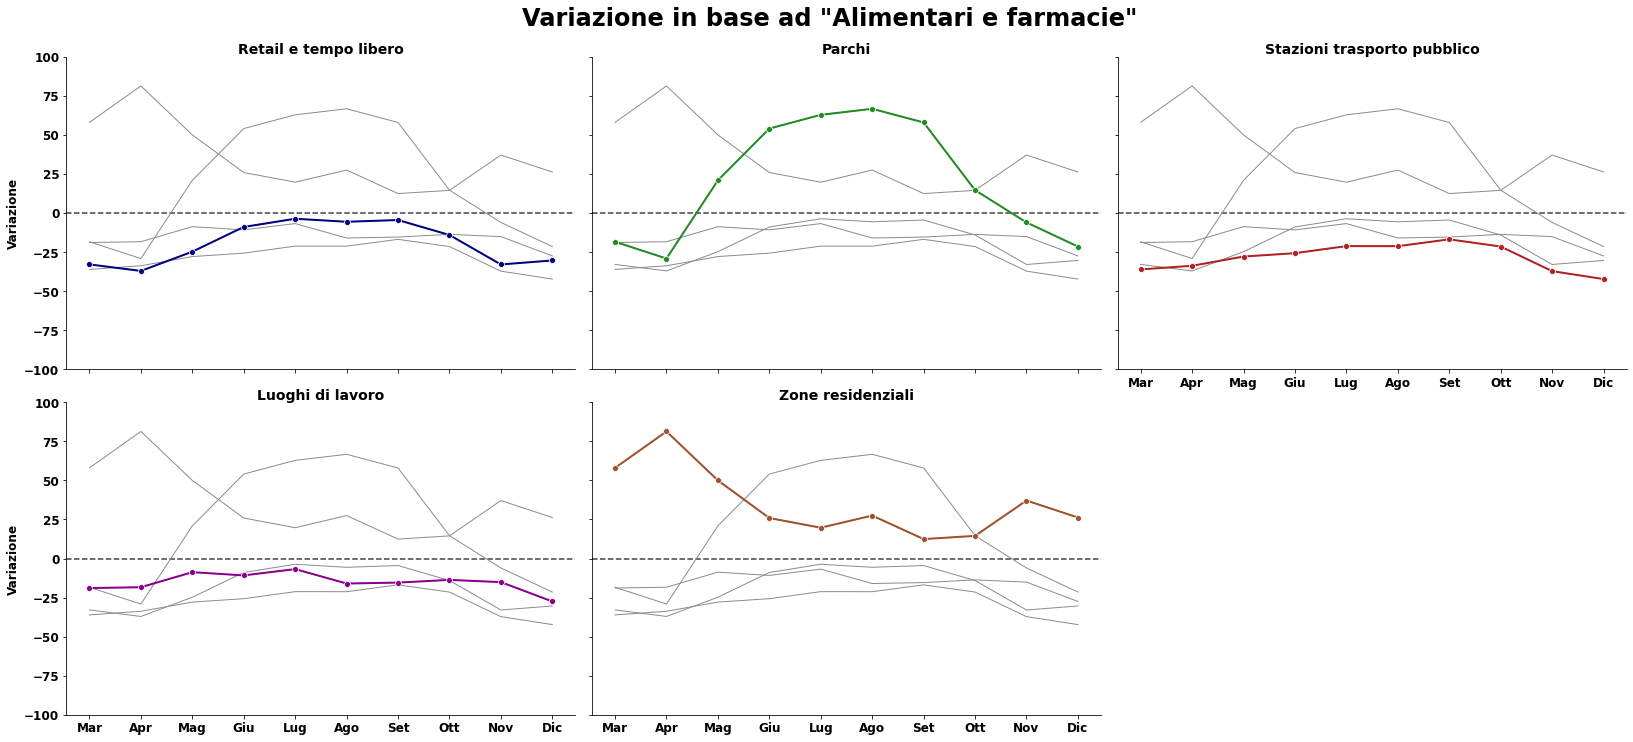

In [19]:
# Si estaggono le medie mensili per tipo e le si mette in una lista.
medie_tipo_mobilità = []
# Per ogni tipo...
for tipo in tipi.values():
    # Si recuperano i suoi dati medi.
    mobilità_tipo_parziale = []
    for record in mobilità_desiderata_per_tipo.iterrows():
        if record[1]['Tipo'] == tipo:
            mobilità_tipo_parziale.append({'Mese': record[1]['Mese'], 'Media': record[1]['Media']})
    # Si aggiunge il dato parziale alla lista.
    medie_tipo_mobilità.append(mobilità_tipo_parziale)

# Si estrae la lista di medie di alimentari e farmacie.
alimentari_e_farmacie = [record['Media'] for record in medie_tipo_mobilità[1]]

# Si ricrea un dataset con la colonna "Alimentari e farmacie".
mobilità_confronto_alimentari = pd.DataFrame(columns=['Mese', 'Tipo', 'Variazione alimentari farmacie'])

# Per ogni lista..
for tipo, media_tipo in zip(range(0, len(medie_tipo_mobilità)), medie_tipo_mobilità):
    # Si saltano i dati relativi ad alimentari e farmacie.
    if tipo == 1:
        continue
    # Per ogni record...
    for indice, record in zip(range(0, len(media_tipo)), media_tipo):
        # ... si calcolano le differenze con alimentari e farmacie.
        variazione = record['Media'] - alimentari_e_farmacie[indice]
        tipoStringa = list(tipi.values())[tipo]
        mobilità_confronto_alimentari = mobilità_confronto_alimentari.append({'Mese':record['Mese'][:3], 'Tipo':tipoStringa, 'Variazione alimentari farmacie':variazione}, ignore_index=True)

# Si crea la palette apposita tolgiento "Alimentari e farmacie".
colori_senza_alimentari = ['navy', 'forestgreen', 'firebrick', 'darkmagenta', 'sienna']
palette_lineplot_senza_alimentari = sns.color_palette(colori_senza_alimentari)

# Si crea la facet contenente i grafici vuoti divisi per tipo.
g = sns.relplot(data=mobilità_confronto_alimentari, x='Mese', y='Variazione alimentari farmacie', col='Tipo', hue='Tipo', kind='line', linewidth=2, zorder=5, col_wrap=3, height=5, aspect=1.5, legend=False, marker="o", palette=palette_lineplot_senza_alimentari)
# Si setta il titolo.
g.fig.suptitle('Variazione in base ad "Alimentari e farmacie"', y=1.0125, fontsize=24, horizontalalignment='center', verticalalignment='center')

# Per ogni sottoplot...
for tipo, ax in g.axes_dict.items():
    # ... si traccia una linea orizzontale sullo zero.
    ax.axhline(0, ls='--', color='black', alpha=0.75)
    # ... si aggiunge il titolo come annotazione...
    ax.text(0.5, 1, tipo, transform=ax.transAxes, fontsize=14, fontweight="bold", ha='center', va='bottom')
    # ... e si mostra il plot del singolo tipo.
    plot = sns.lineplot(data=mobilità_confronto_alimentari, x='Mese', y='Variazione alimentari farmacie', units='Tipo', estimator=None, color='.55', linewidth=1, ax=ax)

# Si settano il titolo dei vari sottografici e le assi.
g.set_titles('')
g.set_axis_labels('', 'Variazione')

# Si settano i limiti dell'asse delle ordinate.
ax.set(ylim=(-100, 100))

# Si salva l'immagine.
plt.savefig('allegati/immagini/tipi/variazione-rispetto-ad-alimentari-e-farmacie.png', bbox_inches='tight')